#### Task:
По нашей статистике, в каждой третьей вакансии работодатели не указывают предлагаемую заработную плату. Поэтому, когда соискатель ищет вакансии только с указанной заработной платой, то теряет часть предложений, релевантных не только по описанию, но и по компенсации.

 В первой задаче нужно предсказать интервал заработной платы на основе данных о вакансии. Была подготовлена обучающая выборка из вакансий с указанными зарплатами (с верхней и нижней границей или с одной из них). Задача – максимально точно предсказать возможную предлагаемую заработную плату, которую мог бы поставить работодатель.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
train = spark.read.json('train.txt')
test = spark.read.json('test.txt')
nosalary = spark.read.json('nosalary.txt')

**Separate task on two different task: min salary and max salary**

In [27]:
train.printSchema()

root
 |-- accept_handicapped: boolean (nullable = true)
 |-- address: struct (nullable = true)
 |    |-- building: string (nullable = true)
 |    |-- city: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- lat: double (nullable = true)
 |    |-- lng: double (nullable = true)
 |    |-- metro: struct (nullable = true)
 |    |    |-- lat: double (nullable = true)
 |    |    |-- line_id: string (nullable = true)
 |    |    |-- line_name: string (nullable = true)
 |    |    |-- lng: double (nullable = true)
 |    |    |-- station_id: string (nullable = true)
 |    |    |-- station_name: string (nullable = true)
 |    |-- metro_stations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- line_id: string (nullable = true)
 |    |    |    |-- line_name: string (nullable = true)
 |    |    |    |-- lng: double (nullable = true)
 |    |    |    |-- station_id: string (

In [6]:
(
    train
    .groupby('salary.currency')
    .count()
    .orderBy('count', ascending=False)
).show()

+--------+------+
|currency| count|
+--------+------+
|     RUR|621955|
|     KZT| 25032|
|     BYR| 24380|
|     UAH| 14345|
|     USD|  9126|
|     EUR|   977|
|     AZN|   822|
|     UZS|    37|
|     KGS|    18|
|     GEL|     6|
+--------+------+



No handles with labels found to put in legend.


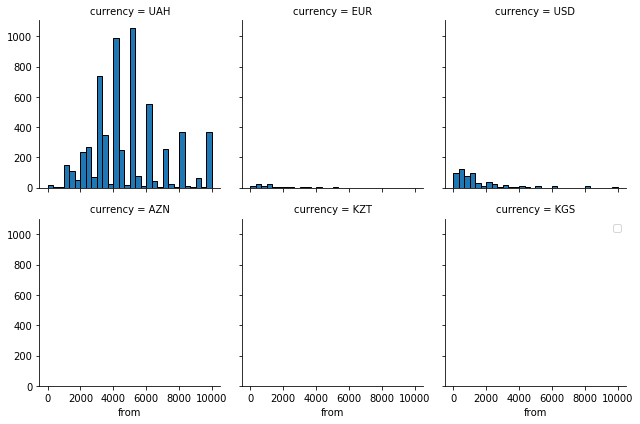

In [26]:
df = (
    train
    .filter('salary.from is not null')
    .filter('area.name == "Киев"')
    .select('salary.currency', 'salary.from')
    .toPandas()
)

g = sns.FacetGrid(df, col="currency", palette="Set1", col_wrap=3)
g.map(plt.hist, 'from', bins=30, range=(0, 10000), ec="k")

g.axes[-1].legend()
plt.show()

In [28]:
train.groupby('area.name').count().orderBy('count', ascending=False).show(3)

+---------------+------+
|           name| count|
+---------------+------+
|         Москва|136275|
|Санкт-Петербург| 52318|
|          Минск| 19306|
+---------------+------+
only showing top 3 rows



In [40]:
(
    data
    .groupby('schedule.name')
    .count()
).show()

+----------------+------+
|            name| count|
+----------------+------+
|     Полный день|412139|
|  Вахтовый метод| 23313|
|Удаленная работа| 18684|
|  Сменный график| 87118|
|   Гибкий график| 34776|
+----------------+------+



In [41]:
data.filter('salary.from == 10').first()

Row(accept_handicapped=False, address=None, allow_messages=True, archived=False, area=Row(id='55', name='Курган', url='https://api.hh.ru/areas/55'), billing_type=Row(id='free', name='Бесплатная'), branded_description=None, code=None, contacts=None, created_at='2015-08-13T13:24:16+0300', department=None, description='<p><strong>Требования:</strong></p> <ul> <li>Требуются АКТИВНЫЕ сотрудники с большим желанием зарабатывать, нацеленные на высокий результат и повышение результативности своей работы</li> <li>Дисциплинированность, исполнительность, стрессоустойчивость, уверенный пользователь ПК, грамотная речь, умение убеждать и настаивать на своём требовании</li> <li>Опыт работы в банковской сфере, коллекторской деятельности и службе судебных приставов приветствуется</li> </ul> <p> </p> <p><strong>Обязанности:</strong></p> <ul> <li>Работа по розыску неплательщиков, скрывающихся от погашения задолженности</li> <li>Проведение переговоров с должниками, клиентами компаний заключение с ними граф

In [31]:
(
    train
    .withColumn('profarea', F.explode('specializations'))
    .groupby('profarea.profarea_name')
    .agg(
        F.count('*').alias('#'),
        F.min('salary.from').alias('min_salary'),
        F.max('salary.from').alias('max_salary'),
    )
    .orderBy('#', ascending=False)
).show(20, False)

+-----------------------------------------------------+------+----------+----------+
|profarea_name                                        |#     |min_salary|max_salary|
+-----------------------------------------------------+------+----------+----------+
|Продажи                                              |855525|1         |150000000 |
|Начало карьеры, студенты                             |174704|1         |21000000  |
|Информационные технологии, интернет, телеком         |141491|1         |100000000 |
|Банки, инвестиции, лизинг                            |119526|1         |20000000  |
|Административный персонал                            |113014|1         |25000000  |
|Маркетинг, реклама, PR                               |111624|1         |50000000  |
|Бухгалтерия, управленческий учет, финансы предприятия|108752|8         |35000000  |
|Строительство, недвижимость                          |105627|1         |98000000  |
|Транспорт, логистика                                 |101173|1  

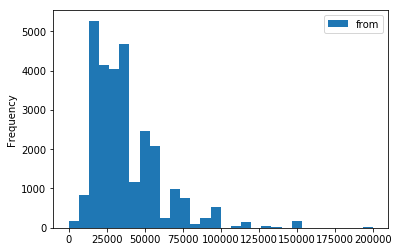

In [49]:
(
    data
    .withColumn('profarea', F.explode('specializations'))
    .filter('profarea.profarea_name == "Юристы"')
    .filter('salary.from > 200000')
).count()

42

In [ ]:
from_data = (
    train.filter('salary.from is not null')
    .select(
        'salary.currency',
        F.col('area.id').alias('city_id'),
    )
)
to_data = (
    train.filter('salary.to is not null')
    .select(
        'salary.currency',
        F.col('area.id').alias('city_id'),
    )
)

In [ ]:
features_columns = ['currency', 'city']

### Train and evaluate

In [ ]:
# Split on train test sets
columns = 
dataset = data[columns]
X = dataset.drop('Id', axis=1)
y = data.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
svr = SVR(degree=5)
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('Mean Squared error:', np.sqrt(mean_squared_error(y_test, pred)))
print('Mean Absolute error:', mean_absolute_error(y_test, pred))